# 1. Instalação de dependências

In [99]:
!pip install -q scikit-learn pandas joblib

# 2. Imports e configurações iniciais

In [100]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score


import joblib

# 3. Função de limpeza de texto

In [101]:
def clean_text(text):
  if not isinstance(text, str):
      return ""
  text = text.lower()
  text = re.sub(r"http\S+|www\S+|@\w+|#", " ", text)
  text = re.sub(r"[^a-záàâãéèêíïóôõöúçñ\s]", " ", text)
  text = re.sub(r"\s+", " ", text).strip()
  return text

# 4. Tratamento de Negações

In [102]:
def handle_negations(text):
  if not isinstance(text, str):
    return ""
  patterns = [
    r"\bnão\s+(\w+)",
    r"\bnao\s+(\w+)",
    r"\bnunca\s+(\w+)",
    r"\bjamais\s+(\w+)"
  ]
  for p in patterns:
      text = re.sub(p, r"nao_\1", text)
  return text

# 5. Tratamento de Intensificadores

In [103]:
def handle_intensifiers(text):
  if not isinstance(text, str):
    return ""
  intensifiers = r"(muito|bem|super|extremamente|bastante|totalmente)"
  text = re.sub(
      rf"\b{intensifiers}\s+(ruim|péssimo|horrível|insatisfeito|decepcionado|bom|ótimo|excelente|confuso)",
      r"\1_\2",
      text
  )
  return text


# 6. Pipeline único de pré-processamento

6.1 Colapsar intensificador + polaridade

In [104]:
def preprocess_text(text):
  text = clean_text(text)
  text = handle_negations(text)
  text = handle_intensifiers(text)
  return text


6.2 Colapso semântico de eventos negativos

In [105]:
# 6.2 Colapso semântico de eventos negativos
def handle_negative_events(text):
    """
    Junta substantivo + evento negativo.
    Ex:
    'entrega atrasou' -> 'entrega_atrasou'
    'caixa amassada'  -> 'caixa_amassada'
    """
    if not isinstance(text, str):
        return ""

    patterns = [
        r"\b(entrega)\s+(atrasou|demorou)",
        r"\b(caixa|produto)\s+(amassada|quebrada|danificada)",
        r"\b(problema)\s+(persistiu|continua)",
    ]

    for p in patterns:
        text = re.sub(p, r"\1_\2", text)

    return text


# 7. Normalização de colunas (fallback)

In [106]:
def normalize_columns(df):
  rename_map = {
    'texto': 'text', 'comentario': 'text', 'comentário': 'text', 'review': 'text',
    'sentimento': 'label', 'classe': 'label', 'rotulo': 'label', 'sentiment': 'label'
  }
  df = df.rename(columns={old: new for old, new in rename_map.items() if old in df.columns})
  if 'text' not in df.columns or 'label' not in df.columns:
      raise ValueError("CSV precisa conter colunas de texto e rótulo")
  return df[['text', 'label']]

# 8. Carregamento do dataset

In [107]:
from google.colab import files
import io


uploaded = files.upload()
filename = list(uploaded.keys())[0]


df = pd.read_csv(
    io.BytesIO(uploaded[filename]),
    sep=",",
    quotechar='"',
    doublequote=True,
    escapechar="\\",
    encoding="utf-8",
    engine="python",
  on_bad_lines="skip"
)


df = normalize_columns(df)
print("Total de registros carregados:", len(df))
display(df.head())


Saving data.csv to data.csv
Total de registros carregados: 2070


,text,label
0,"Produto excelente, chegou rápido e bem embalad...",Positivo
1,"Chegou com defeito, tive que devolver. Péssimo.",Negativo
2,"Entrega no prazo, mas a embalagem veio amassada.",Neutro
3,"Amei demais! Cor perfeita, material ótimo.",Positivo
4,"Demorou 20 dias pra chegar, nunca mais compro ...",Negativo


# 9. Limpeza e pré-processamento dos dados

In [108]:

df['text_clean'] = df['text'].apply(preprocess_text)
df = df[df['text_clean'] != ""]
df['label'] = df['label'].str.strip().str.capitalize()

print(df['label'].value_counts())



label
Negativo    910
Positivo    813
Neutro      346
Name: count, dtype: int64


# 10. Divisão treino / teste (ANTES do oversampling)

In [109]:
X = df['text_clean']
y = df['label']


X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)

# 11. Oversampling manual apenas no treino

In [110]:
# Oversampling manual apenas no conjunto de treino

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
majority_size = train_df['label'].value_counts().max()


balanced_parts = []
for label in train_df['label'].unique():
  subset = train_df[train_df['label'] == label]
  subset_upsampled = resample(
    subset,
    replace=True,
    n_samples=majority_size,
    random_state=42
  )
  balanced_parts.append(subset_upsampled)


train_balanced = pd.concat(balanced_parts).sample(frac=1, random_state=42)
print("Distribuição após oversampling (treino):")
print(train_balanced['label'].value_counts())

Distribuição após oversampling (treino):
label
Positivo    728
Neutro      728
Negativo    728
Name: count, dtype: int64


# 12. Vetorização TF-IDF

In [111]:
tfidf = TfidfVectorizer(
  ngram_range=(1,2),
  min_df=2,
  max_df=0.9,
  sublinear_tf=True
)


X_train_tfidf = tfidf.fit_transform(train_balanced['text'])
X_test_tfidf = tfidf.transform(X_test)


y_train_bal = train_balanced['label']

# 13. Treinamento dos modelos

In [112]:
lr_model = LogisticRegression(
  max_iter=1000,
  class_weight='balanced',
  C=1.0,
  random_state=42
)


svm_model = LinearSVC(
  class_weight='balanced',
  random_state=42
)


lr_model.fit(X_train_tfidf, y_train_bal)
svm_model.fit(X_train_tfidf, y_train_bal)

LinearSVC(class_weight='balanced', random_state=42)

# 14. Avaliação (métricas confiáveis)

In [113]:
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_svm = svm_model.predict(X_test_tfidf)


print('Acurácia LR:', accuracy_score(y_test, y_pred_lr))
print('Acurácia SVM:', accuracy_score(y_test, y_pred_svm))


print('\nRelatório Regressão Logística:\n')
print(classification_report(y_test, y_pred_lr, digits=4))


print('\nRelatório SVM Linear:\n')
print(classification_report(y_test, y_pred_svm, digits=4))

Acurácia LR: 0.9516908212560387
Acurácia SVM: 0.9492753623188406

Relatório Regressão Logística:

              precision    recall  f1-score   support

    Negativo     0.9560    0.9560    0.9560       182
      Neutro     0.9242    0.8841    0.9037        69
    Positivo     0.9578    0.9755    0.9666       163

    accuracy                         0.9517       414
   macro avg     0.9460    0.9385    0.9421       414
weighted avg     0.9514    0.9517    0.9515       414


Relatório SVM Linear:

              precision    recall  f1-score   support

    Negativo     0.9615    0.9615    0.9615       182
      Neutro     0.8873    0.9130    0.9000        69
    Positivo     0.9627    0.9509    0.9568       163

    accuracy                         0.9493       414
   macro avg     0.9372    0.9418    0.9394       414
weighted avg     0.9496    0.9493    0.9494       414



# 15. Matrizes de confusão

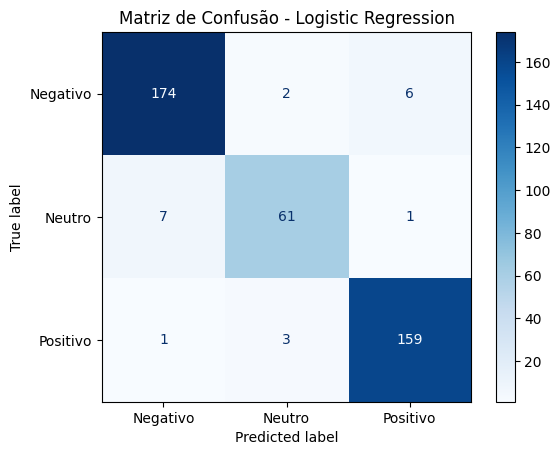

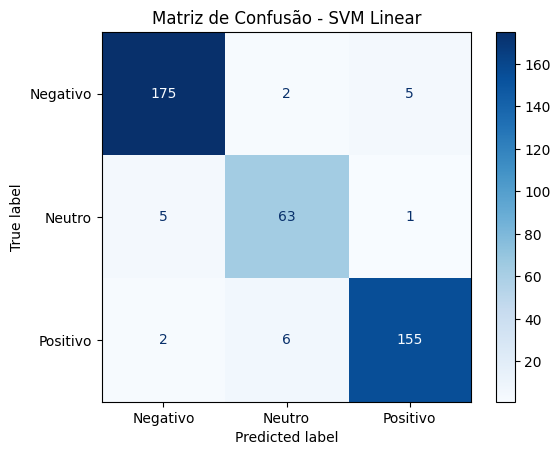

In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ===== Matriz de Confusão - Logistic Regression =====
cm_lr = confusion_matrix(
    y_test,
    y_pred_lr,
    labels=lr_model.classes_
)

disp_lr = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=lr_model.classes_
)

disp_lr.plot(cmap='Blues')
plt.title('Matriz de Confusão - Logistic Regression')
plt.grid(False)
plt.show()


# ===== Matriz de Confusão - SVM Linear =====
cm_svm = confusion_matrix(
    y_test,
    y_pred_svm,
    labels=svm_model.classes_
)

disp_svm = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm,
    display_labels=svm_model.classes_
)

disp_svm.plot(cmap='Blues')
plt.title('Matriz de Confusão - SVM Linear')
plt.grid(False)
plt.show()


# 16. Comparação gráfica: LR vs SVM

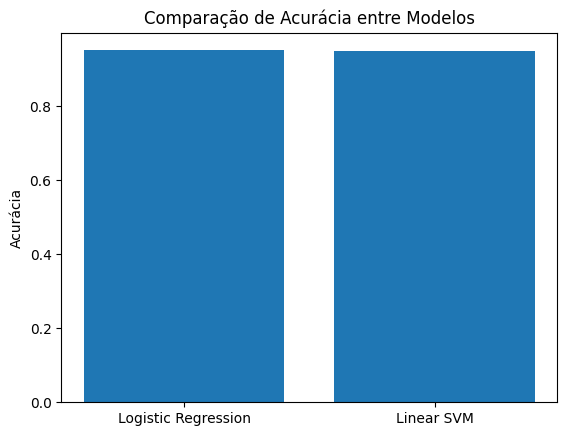

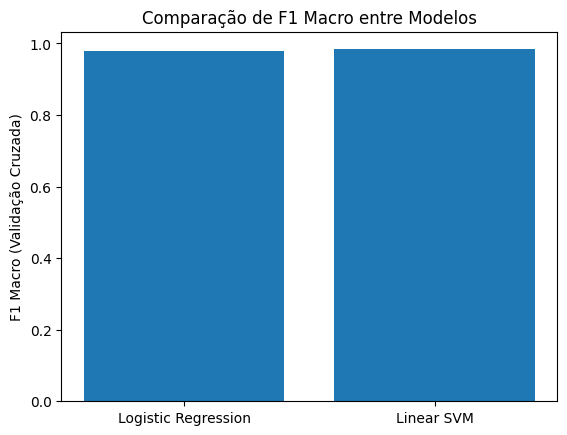

In [118]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Recalcular predições (segurança contra erro de execução fora de ordem)
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_svm = svm_model.predict(X_test_tfidf)

# Recalcular acurácia
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_svm = accuracy_score(y_test, y_pred_svm)

models = ['Logistic Regression', 'Linear SVM']
accuracy_scores = [acc_lr, acc_svm]
f1_scores = [lr_cv_scores.mean(), svm_cv_scores.mean()]

# Gráfico de Acurácia
plt.figure()
plt.bar(models, accuracy_scores)
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.show()

# Gráfico de F1 Macro (Validação Cruzada)
plt.figure()
plt.bar(models, f1_scores)
plt.ylabel('F1 Macro (Validação Cruzada)')
plt.title('Comparação de F1 Macro entre Modelos')
plt.show()


# 17. Validação Cruzada Estratificada

In [115]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


lr_cv_scores = cross_val_score(
  lr_model,
  X_train_tfidf,
  y_train_bal,
  cv=skf,
  scoring='f1_macro'
)


svm_cv_scores = cross_val_score(
  svm_model,
  X_train_tfidf,
  y_train_bal,
  cv=skf,
  scoring='f1_macro'
)


print('LR - Média F1:', lr_cv_scores.mean())
print('SVM - Média F1:', svm_cv_scores.mean())

LR - Média F1: 0.9789265683928411
SVM - Média F1: 0.9835342803462112


# 18. Teste prático – frases novas

In [116]:
frases_teste = [
  "Muito insatisfeito  com o atendimento. Não resolveram meu problema.",
  "Não gostei. A cor é muito diferente da foto do anúncio.",
  "O produto é honesto, cumpre o que promete sem luxos.",
  "A entrega atrasou demais e a caixa chegou amassada.",
  "Simplesmente fantástico, superou todas as minhas expectativas!",
  "Veio quebrado, quero meu dinheiro de volta imediatamente."
]


frases_proc = [preprocess_text(f) for f in frases_teste]
frases_vec = tfidf.transform(frases_proc)


predicoes = lr_model.predict(frases_vec)
probs = lr_model.predict_proba(frases_vec)


pd.DataFrame({
    'Texto': frases_teste,
    'Predição': predicoes,
    'Confiança': probs.max(axis=1)
})

,Texto,Predição,Confiança
0,Muito insatisfeito com o atendimento. Não res...,Positivo,0.496190
1,Não gostei. A cor é muito diferente da foto do...,Negativo,0.684344
2,"O produto é honesto, cumpre o que promete sem ...",Neutro,0.878775
3,A entrega atrasou demais e a caixa chegou amas...,Positivo,0.525896
4,"Simplesmente fantástico, superou todas as minh...",Positivo,0.723553
5,"Veio quebrado, quero meu dinheiro de volta ime...",Negativo,0.894846


# 19. Salvando modelos

In [117]:
joblib.dump(lr_model, 'modelo_lr_sentimentos.pkl')
joblib.dump(svm_model, 'modelo_svm_sentimentos.pkl')
joblib.dump(tfidf, 'tfidf.pkl')


print("Tudo pronto para testes com os modelos salvos ✅")

Tudo pronto para testes com os modelos salvos ✅
